In [7]:
import urllib2
import dateutil.parser
import datetime

def download(date_extension):
    url= 'http://web.mta.info/developers/data/nyct/turnstile/turnstile_' + date_extension +'.txt'
    print(url)
    response = urllib2.urlopen(url)
    data = response.read()

    filename = 'data/' + date_extension + ".txt"
    file_ = open(filename, 'w')
    file_.write(data)
    file_.close()


def calculate_dates(start, end):
    temp = []
    delta = datetime.timedelta(days=7)
    y1, m1, d1 = [int(x) for x in start.strip().split("-")]
    y2, m2, d2 = [int(y) for y in end.strip().split("-")]
    sDate = datetime.datetime(y1, m1, d1)
    eDate = datetime.datetime(y2, m2, d2)
    d = sDate
    while d <= eDate:
        # d.strftime("%y%m%d")
        temp.append(d)
        d += delta
        
    return temp


#for i in datesList:
#    download(i)


#download('161231')

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from IPython.display import Image
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 25)
pd.set_option('display.precision', 3)
# enables inline plots, without it plots don't show up in the notebook
%matplotlib inline


def calculate_total_week(date, cumulative_df):
    
    date_extension = date.strftime("%y%m%d")
    filename = 'data/' + date_extension + '.txt'
    df1 = pd.read_csv(filename)

    df1.columns = df1.columns.str.strip()
    #subsetting the stations we want
    df=df1[(df1.STATION=='TIMES SQ-42 ST')| (df1.STATION=='FLUSHING-MAIN' )| (df1.STATION=='ATL AV-BARCLAY')]
    
    #start of analysis for weekly counts##
    station_date=df.groupby(['C/A','UNIT','SCP','STATION','DATE'])
    entry_date_count=station_date.ENTRIES.apply(lambda x: x.max() - x.min())
    entry_date_count=entry_date_count.reset_index()


    exit_date_count=station_date.EXITS.apply(lambda x: x.max() - x.min())
    exit_date_count=exit_date_count.reset_index()



    #group all entries by station#
    station_entry_week_count=entry_date_count.groupby('STATION').ENTRIES.agg(['sum'])

    station_exit_week_count=exit_date_count.groupby('STATION').EXITS.agg(['sum'])


    #total counts
    station_entry_week_count['exit sum']=station_exit_week_count['sum']
    station_entry_week_count['total']=station_entry_week_count['exit sum']+station_entry_week_count['sum']
    station_entry_week_count['year_week']=date
    station_entry_week_count= station_entry_week_count.reset_index()
   
    cumulative_df = cumulative_df.append(station_entry_week_count.iloc[:])
    return cumulative_df

datesList = calculate_dates('2016-06-25', '2017-06-24')
final_week_count=pd.DataFrame()
for d in datesList:
    final_week_count = calculate_total_week(d, final_week_count)
    
    #changing the dates to datetime for plotting
''' 
dates=[]
for i in range(0,len(entry_date_count)):
    dates.append(dateutil.parser.parse(entry_date_count.iloc[i,4]))
entry_date_count['DATE_NEW']=dates
'''

In [25]:
final_week_count.to_csv(r'final_results.txt', header=True, sep=',')

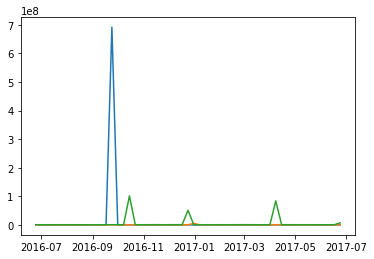

In [24]:


bp = final_week_count.groupby('STATION')
total = final_week_count['total']

atl_station = final_week_count[final_week_count.STATION == 'ATL AV-BARCLAY']
flushing_station = final_week_count[final_week_count.STATION == 'FLUSHING-MAIN']
times_station = final_week_count[final_week_count.STATION == 'TIMES SQ-42 ST']


#plt.ylim(ymax=np.percentile(final_week_count.total))
#final_outout = final_week_count.groupby('STATION')
plt.plot(atl_station.year_week, atl_station.total)
plt.plot(flushing_station.year_week, flushing_station.total)
plt.plot(times_station.year_week, times_station.total)

#np.percentile(final_week_count.total, 99)


In [ ]:
np.percentile(final_week_count.total, 99)